### Data collection

In real life, you may have collected your own data but ReLife also provides built-in datasets so that you can start learning ReLife. For this example,
we will use the *power transformer dataset*. If you don't know what a power transformer is, you can look at [the decicated Wikipedia page](https://en.wikipedia.org/wiki/Transformer)
To load this dataset, you must import the function ``load_power_transformer``

In [1]:
from relife.data import load_power_transformer
data = load_power_transformer()

Here ``data`` is a [structured array](https://numpy.org/doc/stable/user/basics.rec.html>) object that contains three fields :

- ``time`` : the observed lifetime values
- ``event`` : the event indicators tagging each observations as complete (``True``) or censored (``False``)
- ``entry`` : the left truncation values

In [2]:
print(data["event"])
print(data["event"])
print(data["entry"])

[ True  True  True ... False False False]
[ True  True  True ... False False False]
[34. 44. 52. ...  0.  0.  0.]


### Lifetime model estimation

For the obtained data you can fit a lifetime model. In this example, we use a simple lifetime model : a Weibull lifetime distribution.

In [3]:
from relife.lifetime_model import Weibull
weibull = Weibull()
weibull.fit(
    data["time"],
    event=data["event"],
    entry=data["entry"],
)
print(weibull.params_names, weibull.params)

('shape', 'rate') [3.46597396 0.0122785 ]


Note that these model objects hold ```params`` values and that the ``fit`` has modified them inplace.

<Axes: >

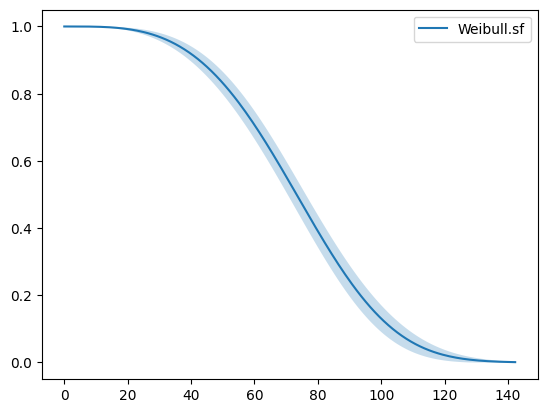

In [4]:
weibull.plot.sf()

### Maintenance policy optimization

Now let's consider that we want the study an age replacement policy. You need to know :

- the cost of a preventive replacement $c_p$
- the cost of an unexpected failure  $c_f$
- the current ages of your assets

For this example, we will fix $c_p$ at 3 millions of euros and $c_f$ at 11 millions of euros. For the sake of the illustration, we
will sample 1000 age values for a binomial distribution to represent the current ages of the assets. So here, we consider **a fleet of 1000 assets**.

In [5]:
import numpy as np
cp = 3. # cost of preventive replacement
cf = 11. # cost of failure
a0 = np.random.binomial(60, 0.5, 1000) # asset ages

Now you can use these values with the previous lifetime model to optimize an age replacement policy

In [6]:
from relife.policy import AgeReplacementPolicy
policy = AgeReplacementPolicy(
    weibull,
    cf=cf,
    cp=cp,
    a0=a0,
    discounting_rate=0.04,
).optimize()

The obtained object encapsulates two age replacement arrays of 1000 values (because we considered 1000 assets). These data are stored in ``ar1`` for the first ages of replacements and ``ar`` for every next ages of replacement. You can print them.

In [7]:
print(policy.ar1.shape)
print(policy.ar1[:5])
print(policy.ar.shape)
print(policy.ar[:5])

(1000,)
[29.79427714 28.42187901 27.08888713 31.92366325 37.19567492]
(1000,)
[59.19751205 59.19751205 59.19751205 59.19751205 59.19751205]


### Projection of consequences

Now that we a optimized an age replacement policy, we can project the consequences of this strategy. For instance, you can be interested in seeing the expected number of replacements and number of failures for the next 170 years.

In [8]:
nb_years = 170
timeline, nb_replacements, nb_failures = policy.annual_number_of_replacements(nb_years, upon_failure=True)
%timeit policy.annual_number_of_replacements(nb_years, upon_failure=True)

644 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To do that, ReLife solves the renewal equation.

In [9]:
print(timeline.shape)
print(nb_replacements.shape)
print(nb_failures.shape)

(170,)
(170,)
(170,)


The returned objects are arrays of with 170 values, one value for each upcoming years. Here, ReLife does not offer built-in plot functionnalities. But of course, you can use [matplotlib](https://matplotlib.org/) code to represent these values in one graph

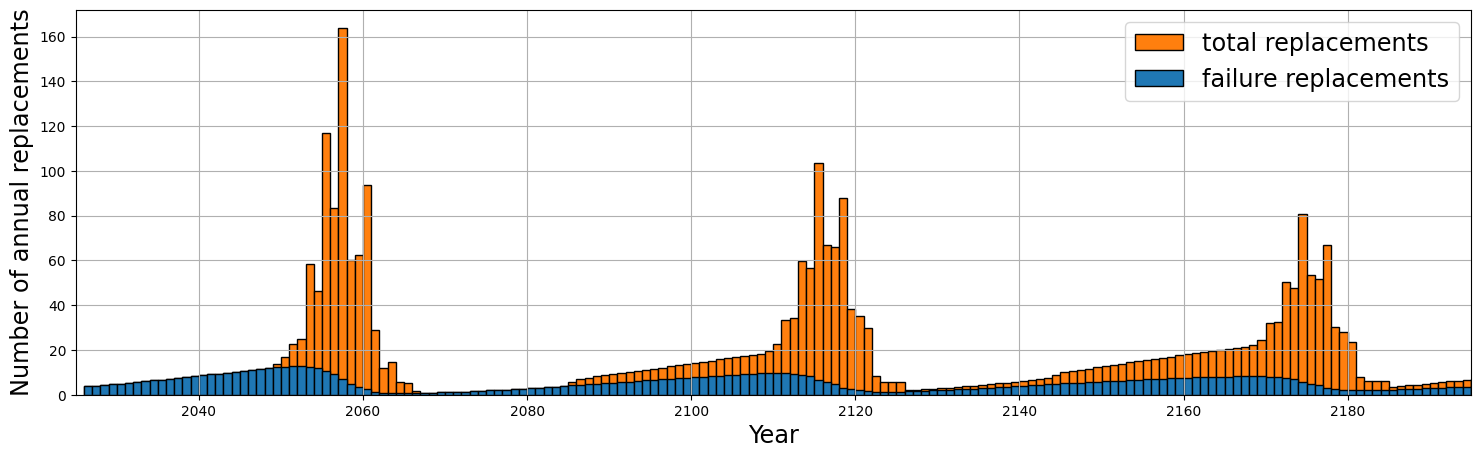

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 5),  dpi=100)
ax.bar(timeline + 2025, nb_replacements, align="edge", width=1., label="total replacements", color="C1", edgecolor="black")
ax.bar(timeline + 2025, nb_failures, align="edge", width=1., label="failure replacements", color="C0", edgecolor="black")
ax.set_ylabel("Number of annual replacements", fontsize="xx-large")
ax.set_xlabel("Year", fontsize="xx-large")
ax.set_ylim(bottom=0)
ax.set_xlim(left=2025, right=2025 + nb_years)
ax.legend(loc="upper right", fontsize="xx-large")
plt.grid(True)
plt.show()